### Load Imports

In [ ]:
import pandas as pd
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors



## Load Dataset


In [ ]:
path = kagglehub.dataset_download("ulrikthygepedersen/fastfood-nutrition")

print("Path to dataset files:", path)

df = pd.read_csv(os.path.join(path, "fastfood.csv"))

100%|██████████| 11.8k/11.8k [00:00<00:00, 20.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ulrikthygepedersen/fastfood-nutrition/versions/1


## Inspect Data



In [ ]:
df.head(10)

,restaurant,item,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,vit_a,vit_c,calcium,salad
0,Mcdonalds,Artisan Grilled Chicken Sandwich,380,60,7,2.0,0.0,95,1110,44,3.0,11,37.0,4.0,20.0,20.0,Other
1,Mcdonalds,Single Bacon Smokehouse Burger,840,410,45,17.0,1.5,130,1580,62,2.0,18,46.0,6.0,20.0,20.0,Other
2,Mcdonalds,Double Bacon Smokehouse Burger,1130,600,67,27.0,3.0,220,1920,63,3.0,18,70.0,10.0,20.0,50.0,Other
3,Mcdonalds,Grilled Bacon Smokehouse Chicken Sandwich,750,280,31,10.0,0.5,155,1940,62,2.0,18,55.0,6.0,25.0,20.0,Other
4,Mcdonalds,Crispy Bacon Smokehouse Chicken Sandwich,920,410,45,12.0,0.5,120,1980,81,4.0,18,46.0,6.0,20.0,20.0,Other
5,Mcdonalds,Big Mac,540,250,28,10.0,1.0,80,950,46,3.0,9,25.0,10.0,2.0,15.0,Other
6,Mcdonalds,Cheeseburger,300,100,12,5.0,0.5,40,680,33,2.0,7,15.0,10.0,2.0,10.0,Other
7,Mcdonalds,Classic Chicken Sandwich,510,210,24,4.0,0.0,65,1040,49,3.0,6,25.0,0.0,4.0,2.0,Other
8,Mcdonalds,Double Cheeseburger,430,190,21,11.0,1.0,85,1040,35,2.0,7,25.0,20.0,4.0,15.0,Other
9,Mcdonalds,Double Quarter Pounder® with Cheese,770,400,45,21.0,2.5,175,1290,42,3.0,10,51.0,20.0,6.0,20.0,Other


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   restaurant   515 non-null    object 
 1   item         515 non-null    object 
 2   calories     515 non-null    int64  
 3   cal_fat      515 non-null    int64  
 4   total_fat    515 non-null    int64  
 5   sat_fat      515 non-null    float64
 6   trans_fat    515 non-null    float64
 7   cholesterol  515 non-null    int64  
 8   sodium       515 non-null    int64  
 9   total_carb   515 non-null    int64  
 10  fiber        503 non-null    float64
 11  sugar        515 non-null    int64  
 12  protein      514 non-null    float64
 13  vit_a        301 non-null    float64
 14  vit_c        305 non-null    float64
 15  calcium      305 non-null    float64
 16  salad        515 non-null    object 
dtypes: float64(7), int64(7), object(3)
memory usage: 68.5+ KB


In [ ]:
df.restaurant.value_counts()

,count
restaurant,
Taco Bell,115
Subway,96
Burger King,70
Mcdonalds,57
Arbys,55
Sonic,53
Dairy Queen,42
Chick Fil-A,27


## Data Pre-Processing


#### Handle Missing Values


In [ ]:
df.isnull().sum()

,0
restaurant,0
item,0
calories,0
cal_fat,0
total_fat,0
sat_fat,0
trans_fat,0
cholesterol,0
sodium,0
total_carb,0


In [ ]:
duplicate_rows = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

if duplicate_rows > 0:
    print("\nDuplicate rows:")
    display(df[df.duplicated()])
else:
    print("No duplicate rows found.")

Number of duplicate rows: 2

Duplicate rows:


,restaurant,item,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,vit_a,vit_c,calcium,salad
492,Taco Bell,Chili Cheese Burrito,380,150,17,8.0,1.0,35,930,41,5.0,2,16.0,NaN,NaN,NaN,Other
511,Taco Bell,Express Taco Salad w/ Chips,580,260,29,9.0,1.0,60,1270,59,8.0,7,23.0,NaN,NaN,NaN,Other


In [ ]:
df.drop_duplicates(inplace=True)
print(f"Number of duplicate rows after dropping: {df.duplicated().sum()}")

Number of duplicate rows after dropping: 0


#### Drop Columns for missing inputs and not needed



In [ ]:
df.drop(columns=['vit_a','vit_c','calcium','salad','cal_fat'],axis=1,inplace=True)

df.fiber.fillna(df.fiber.mean(),inplace=True)
df.protein.fillna(df.protein.mean(),inplace=True)

/tmp/ipython-input-4147284748.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.fiber.fillna(df.fiber.mean(),inplace=True)
/tmp/ipython-input-4147284748.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [ ]:
numerical_cols = ['calories', 'total_fat', 'sodium', 'fiber', 'sugar', 'protein']


for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

## EDA

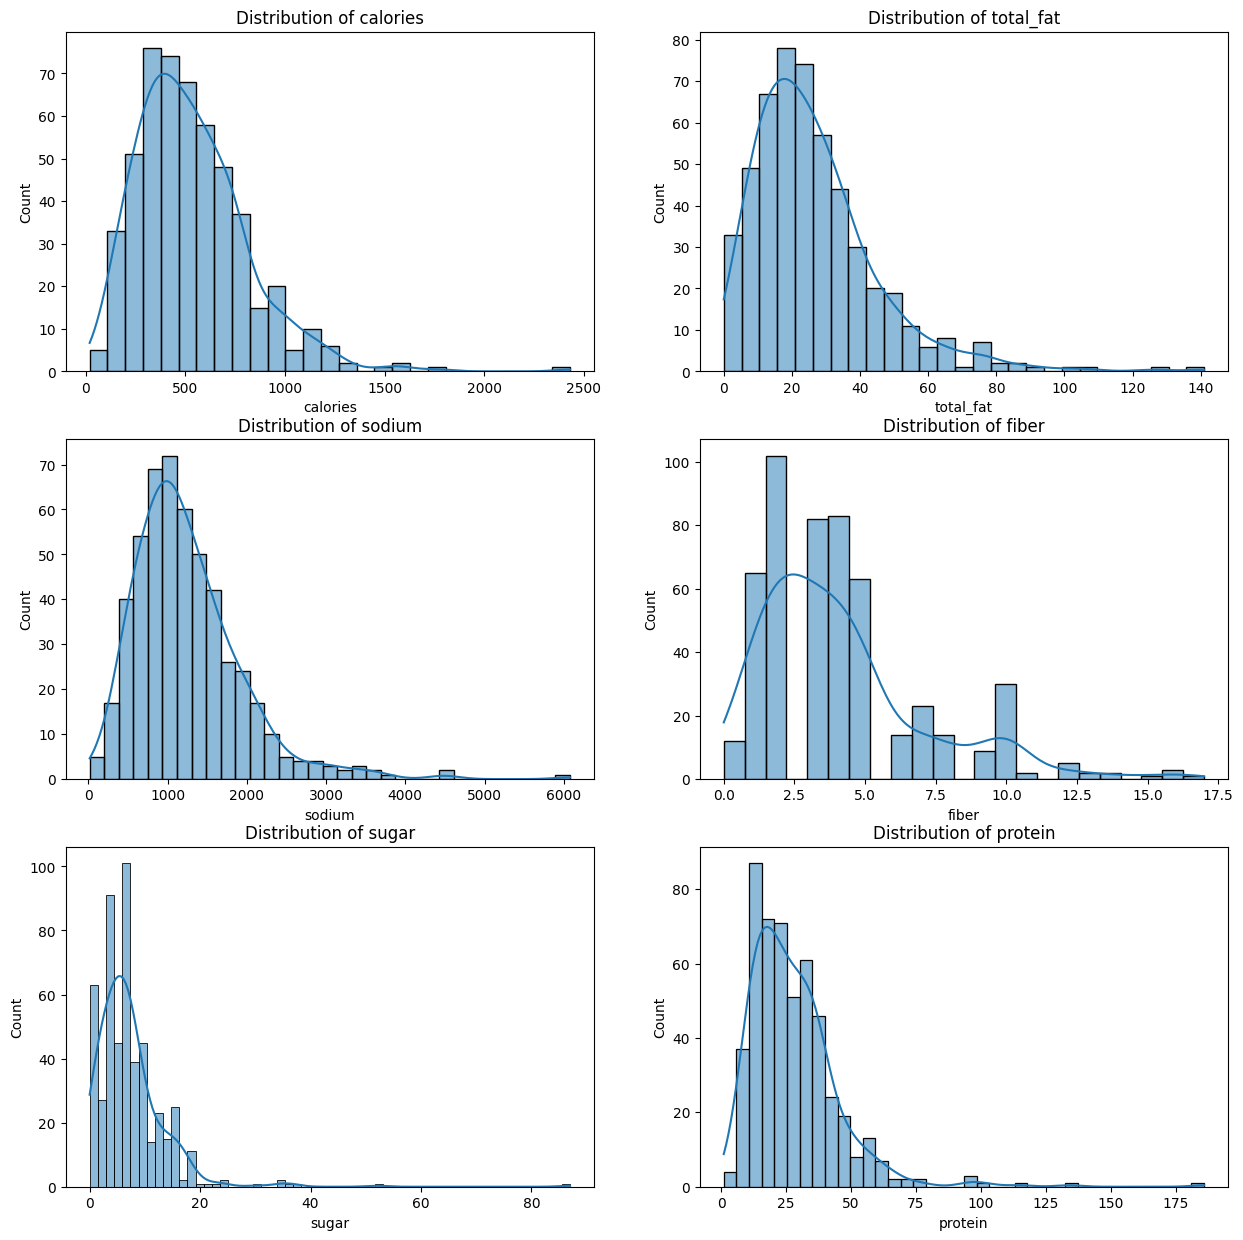

<Figure size 600x400 with 0 Axes>

In [ ]:
num_cols = len(numerical_cols)
fig, axes = plt.subplots(nrows=(num_cols + 1) // 2, ncols=2, figsize=(15, 5 * ((num_cols + 1) // 2)))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.figure(figsize=(6,4))  # Not too tall
plt.savefig("figure.png", dpi=300, bbox_inches='tight')

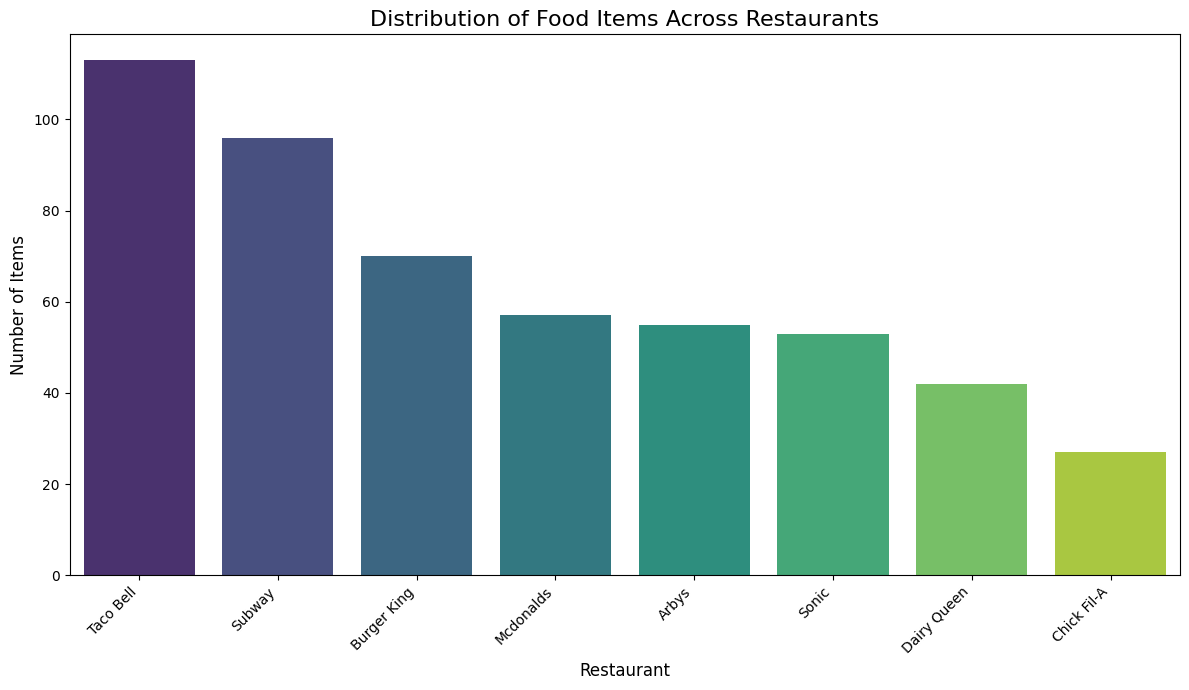

<Figure size 600x400 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

restaurant_counts = df['restaurant'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=restaurant_counts.index, y=restaurant_counts.values, hue=restaurant_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Food Items Across Restaurants', fontsize=16)
plt.xlabel('Restaurant', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.figure(figsize=(6,4))  # Not too tall
plt.savefig("redistribution", dpi=300, bbox_inches='tight')



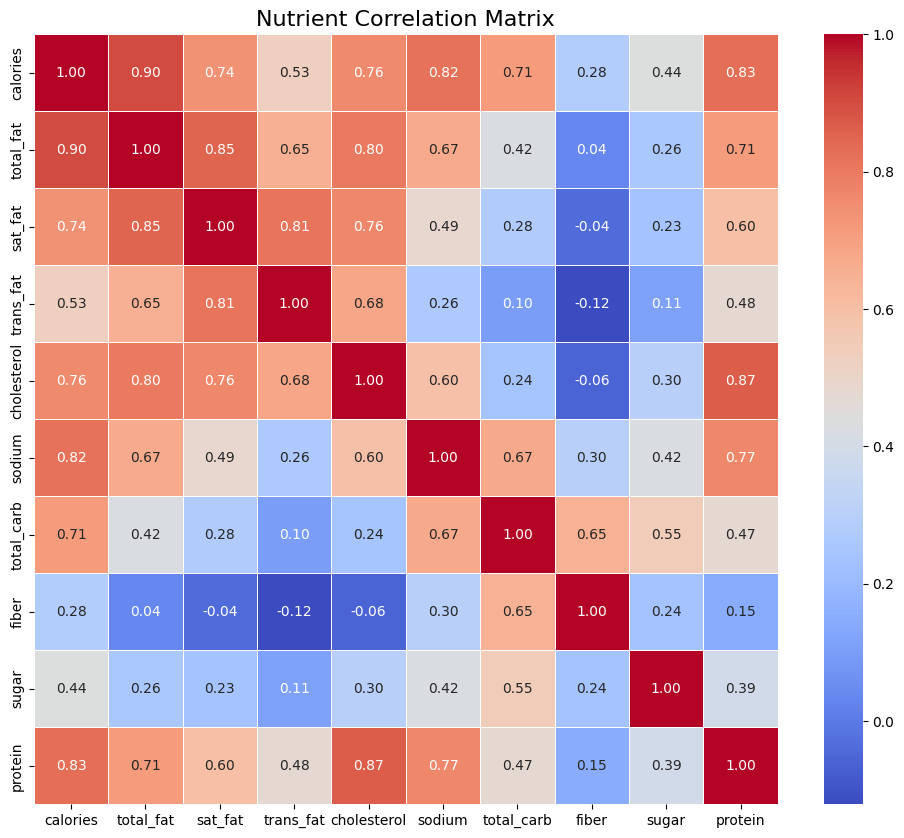

In [ ]:
plt.figure(figsize=(12, 10))

# Calculate correlation matrix
corr = df.drop(columns=['restaurant', 'item']).corr()

# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Nutrient Correlation Matrix', fontsize=16)

# Save the heatmap
plt.savefig('nutrient_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

#### Final Features

In [ ]:
df.drop(columns=['sat_fat', 'trans_fat', 'cholesterol', 'total_carb'],axis=1,inplace=True)

In [ ]:
numerical_cols = ['calories', 'total_fat', 'sodium', 'fiber', 'sugar', 'protein']


for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#### Updated Correlational Matrix

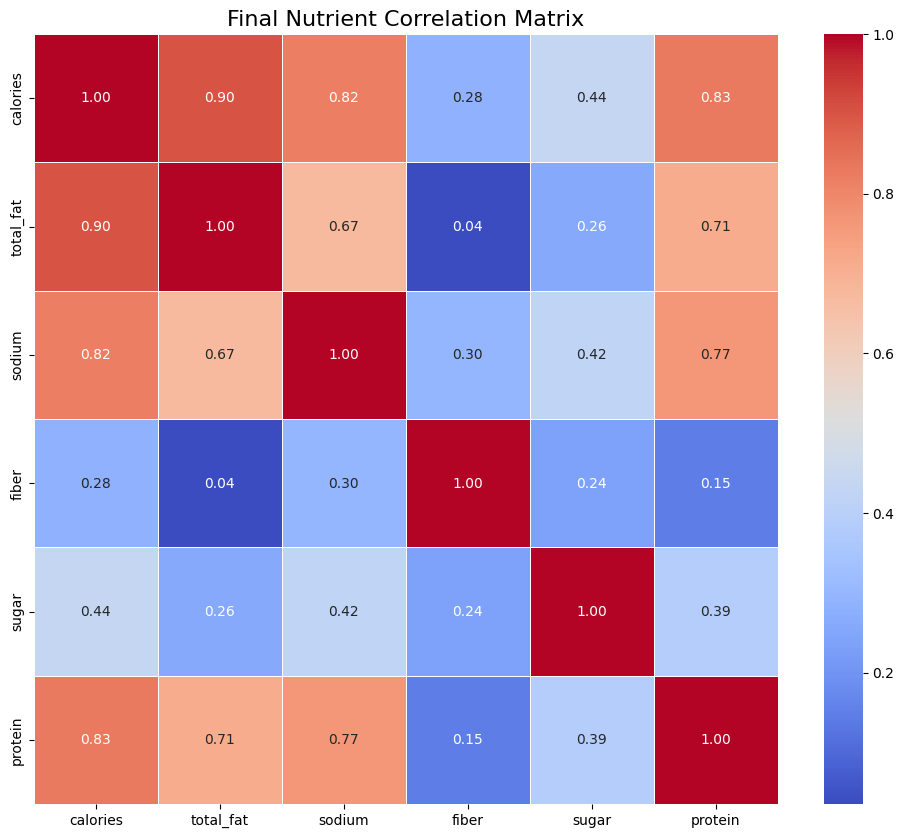

In [ ]:
plt.figure(figsize=(12, 10))

# Calculate correlation matrix
corr = df.drop(columns=['restaurant', 'item']).corr()

# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Final Nutrient Correlation Matrix', fontsize=16)

# Save the heatmap
plt.savefig('new_nutrient_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

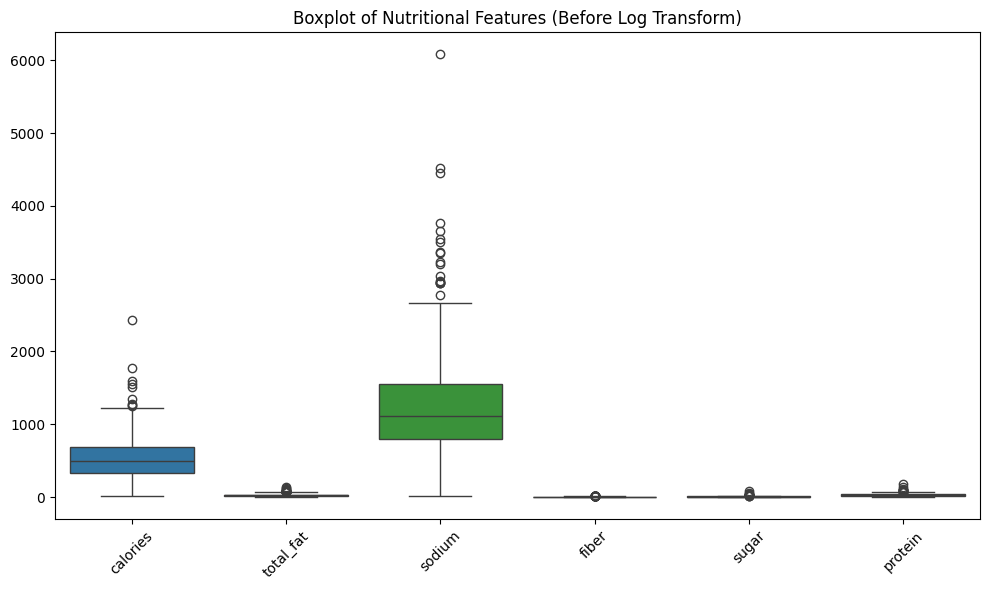

In [48]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_cols])
plt.xticks(rotation=45)
plt.title("Boxplot of Nutritional Features (Before Log Transform)")
plt.tight_layout()
plt.savefig('boxplot_before_log_transform.png', dpi=300, bbox_inches='tight')
plt.show()

## Skewness

In [ ]:
skewed_cols = ['calories', 'total_fat', 'sodium', 'fiber', 'sugar', 'protein']

# Save original copy
df_original = df.copy()

# Compute skew before
skew_before = df_original[skewed_cols].skew()

# Apply log transform
df_log = df_original.copy()
for col in skewed_cols:
    df_log[col] = np.log1p(df_log[col])

# Compute skew after
skew_after = df_log[skewed_cols].skew()

# Combine into one table
skew_comparison = pd.DataFrame({
    "Skew Before": skew_before,
    "Skew After Log": skew_after
})

skew_comparison



,Skew Before,Skew After Log
calories,1.410725,-0.755517
total_fat,1.788111,-0.635376
sodium,1.801018,-1.545219
fiber,1.414107,-0.069142
sugar,4.606380,-0.516868
protein,2.808887,-0.202829


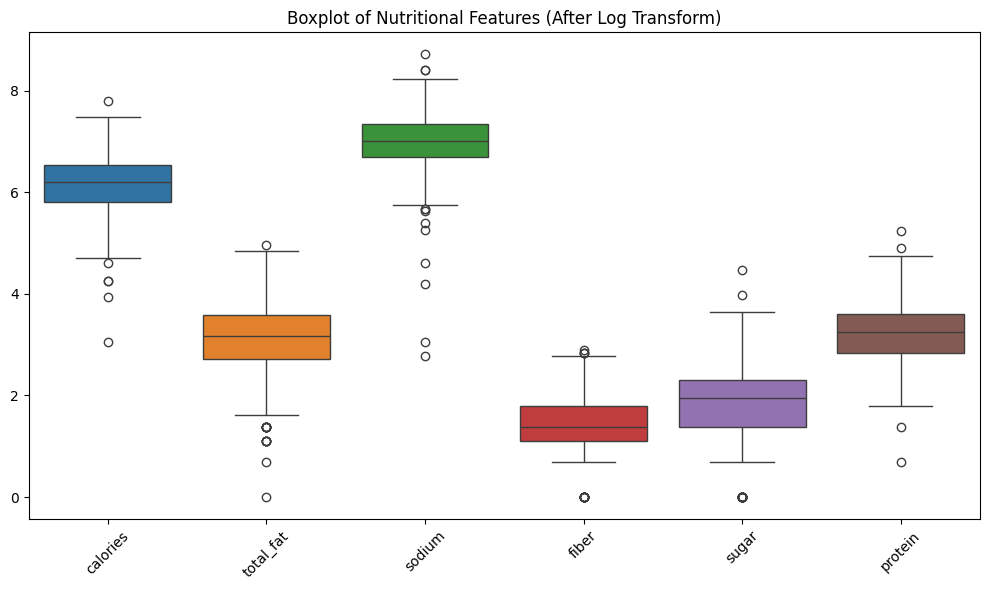

In [47]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_log[numerical_cols])
plt.xticks(rotation=45)
plt.title("Boxplot of Nutritional Features (After Log Transform)")
plt.tight_layout()
plt.savefig('boxplot_after_log_transform.png', dpi=300, bbox_inches='tight')
plt.show()

## Standard Scaler

In [ ]:
numerical_cols = ['calories', 'total_fat', 'sodium', 'fiber', 'sugar', 'protein']

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_log[numerical_cols])

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=numerical_cols)

df_scaled.head()


,calories,total_fat,sodium,fiber,sugar,protein
0,-0.331999,-1.448375,0.059246,-0.164711,0.836946,0.762365
1,1.057733,1.036525,0.643497,-0.676144,1.450845,1.142736
2,1.577731,1.591787,0.966077,-0.164711,1.450845,1.880949
3,0.859072,0.520984,0.983229,-0.676144,1.450845,1.456258
4,1.217223,1.036525,1.017010,0.231987,1.450845,1.142736


##  PCA

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_scaled)

print("Number of components retained:", pca.n_components_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())

print("Explained variance of PC1:", pca.explained_variance_ratio_[0])
print("Explained variance of PC2:", pca.explained_variance_ratio_[1])
print("Explained variance of PC3:", pca.explained_variance_ratio_[2])


Number of components retained: 3
Total explained variance: 0.8951574781930519
Explained variance of PC1: 0.6132104530860565
Explained variance of PC2: 0.17992044408623206
Explained variance of PC3: 0.10202658102076335


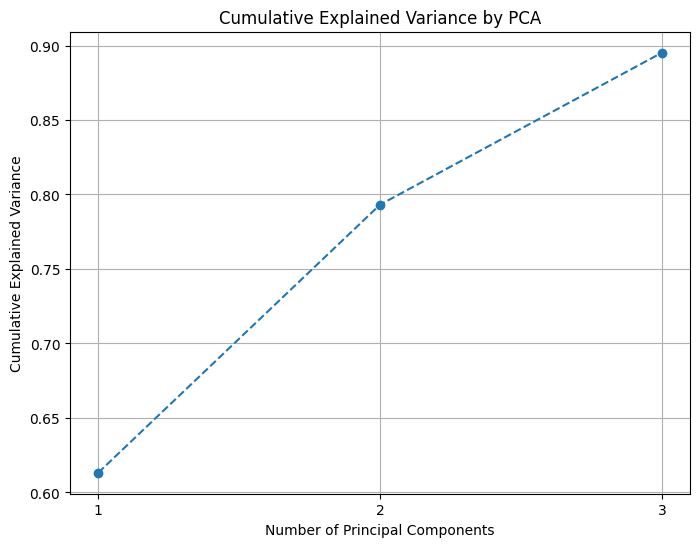

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid()
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))

# Save the plot as PNG
plt.savefig('pca_variance_plot.png', dpi=300, bbox_inches='tight')

In [ ]:
pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(df_scaled)

print("Number of components retained:", pca.n_components_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())

print("Explained variance of PC1:", pca.explained_variance_ratio_[0])
print("Explained variance of PC2:", pca.explained_variance_ratio_[1])


Number of components retained: 2
Total explained variance: 0.7931308971722886
Explained variance of PC1: 0.6132104530860565
Explained variance of PC2: 0.17992044408623206


## Scatter Plot

In [ ]:
import plotly.express as px

# Create a DataFrame for Plotly
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3',
                    title='3D Scatter Plot of PCA Components (Plotly)',
                    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'})

fig.show()

# Clustering

#### K Means

Plot saved as: elbow_method_plot.png


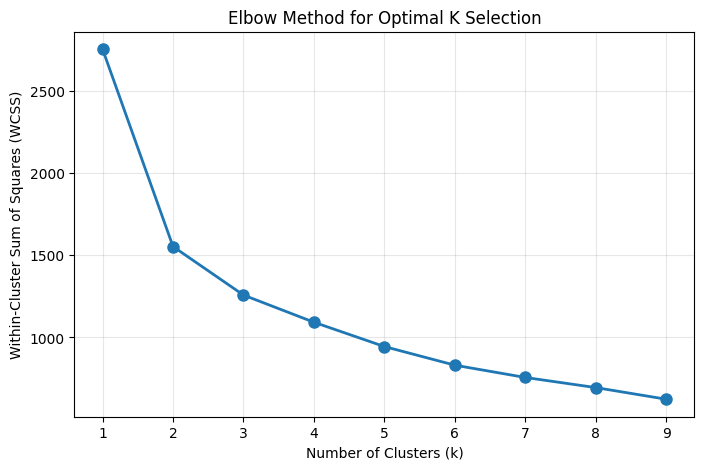

In [ ]:
wcss = []
k_values = range(1, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # inertia = WCSS

plt.figure(figsize=(8,5))
plt.plot(k_values, wcss, marker='o', linewidth=2, markersize=8)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal K Selection")
plt.xticks(k_values)
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig('elbow_method_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
print("Plot saved as: elbow_method_plot.png")

plt.show()

In [ ]:

results = []
ks = range(2, 7)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    dbi = davies_bouldin_score(X_pca, labels)
    chi = calinski_harabasz_score(X_pca, labels)

    results.append({
        "k": k,
        "Silhouette": round(sil, 4),
        "DBI": round(dbi, 4),
        "CHI": round(chi, 2)
    })

metrics_df = pd.DataFrame(results)
print("K-Means (k=3) Results:")
print("Silhouette:", metrics_df[metrics_df['k'] == 3]['Silhouette'].iloc[0])
print("DBI:", metrics_df[metrics_df['k'] == 3]['DBI'].iloc[0])
print("CHI:", metrics_df[metrics_df['k'] == 3]['CHI'].iloc[0])

K-Means (k=3) Results:
Silhouette: 0.2869
DBI: 1.1646
CHI: 303.54


#### Agglomerative Clustering

In [ ]:
agg_results = []
ks = range(2, 7)

for k in ks:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_pca)

    sil = silhouette_score(X_pca, labels)
    dbi = davies_bouldin_score(X_pca, labels)
    chi = calinski_harabasz_score(X_pca, labels)

    agg_results.append({
        "k": k,
        "Silhouette": round(sil, 4),
        "DBI": round(dbi, 4),
        "CHI": round(chi, 2)
    })

agg_df = pd.DataFrame(agg_results)
print("Agglomerative (k=3) Results:")
print("Silhouette:", agg_df[agg_df['k'] == 3]['Silhouette'].iloc[0])
print("DBI:", agg_df[agg_df['k'] == 3]['DBI'].iloc[0])
print("CHI:", agg_df[agg_df['k'] == 3]['CHI'].iloc[0])

Agglomerative (k=3) Results:
Silhouette: 0.2288
DBI: 1.285
CHI: 255.52


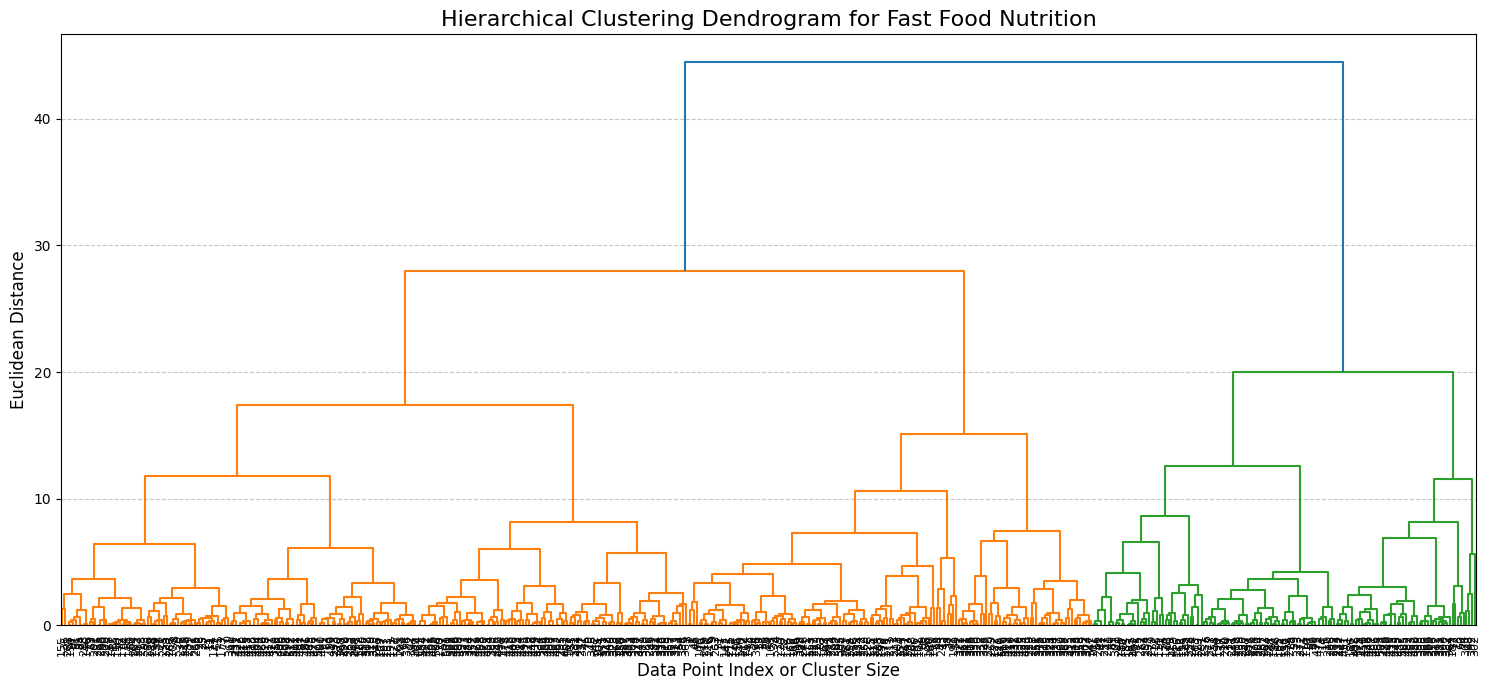

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_pca, method='ward')

plt.figure(figsize=(15, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_rotation=90.
          )
plt.title('Hierarchical Clustering Dendrogram for Fast Food Nutrition', fontsize=16)
plt.xlabel('Data Point Index or Cluster Size', fontsize=12)
plt.ylabel('Euclidean Distance', fontsize=12)
plt.tick_params(axis='x', labelsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

#### DBSCAN

In [69]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(X_pca)

# Count clusters (excluding noise)
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise = np.sum(labels_db == -1)

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)

mask = labels_db != -1

if n_clusters >= 2:
    sil = silhouette_score(X_pca[mask], labels_db[mask])
    dbi = davies_bouldin_score(X_pca[mask], labels_db[mask])
    chi = calinski_harabasz_score(X_pca[mask], labels_db[mask])

    print("DBSCAN Results:")
    print("Silhouette:", round(sil, 4))
    print("DBI:", round(dbi, 4))
    print("CHI:", round(chi, 2))
else:
    print("Not enough clusters formed.")

Clusters found: 7
Noise points: 134
DBSCAN Results:
Silhouette: 0.1305
DBI: 0.8479
CHI: 58.82


In [70]:
comparison = pd.DataFrame([
    {
        "Model": "K-Means (k=3)",
        "Silhouette": metrics_df[metrics_df['k'] == 3]['Silhouette'].iloc[0],
        "DBI": metrics_df[metrics_df['k'] == 3]['DBI'].iloc[0],
        "CHI": metrics_df[metrics_df['k'] == 3]['CHI'].iloc[0]
    },
    {
        "Model": "Agglomerative (k=3)",
        "Silhouette": agg_df[agg_df['k'] == 3]['Silhouette'].iloc[0],
        "DBI": agg_df[agg_df['k'] == 3]['DBI'].iloc[0],
        "CHI": agg_df[agg_df['k'] == 3]['CHI'].iloc[0]
    },
    {
        "Model": "DBSCAN",
        "Silhouette": sil,
        "DBI": dbi,
        "CHI": chi
    }
])

comparison

,Model,Silhouette,DBI,CHI
0,K-Means (k=3),0.286900,1.16460,303.540000
1,Agglomerative (k=3),0.228800,1.28500,255.520000
2,DBSCAN,0.130489,0.84786,58.821039


## Profiling the Clusters

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

df_results = df_original.copy()
df_results["Cluster"] = labels


In [ ]:
cluster_profile = df_results.groupby("Cluster")[
    ['calories','total_fat','sodium','fiber','sugar','protein']
].mean().round(2)

cluster_profile


,calories,total_fat,sodium,fiber,sugar,protein
Cluster,,,,,,
0,398.30,18.74,967.92,3.74,5.47,20.60
1,770.00,40.00,1767.29,5.13,10.59,40.23
2,194.34,8.88,487.24,2.25,2.47,11.91


In [ ]:
risk_map = {
    2: "Low Risk",
    0: "Moderate Risk",
    1: "High Risk"
}

df_results["Risk_Level"] = df_results["Cluster"].map(risk_map)


In [ ]:
fig = px.scatter_3d(
    pca_df.assign(Risk_Level=df_results["Risk_Level"]),
    x="PC1",
    y="PC2",
    z="PC3",
    color="Risk_Level",
    title="3D PCA Clustering by Nutritional Risk"
)

fig.update_traces(marker=dict(size=4))
fig.show()

In [ ]:
top_per_risk = (
    df_results
    .sort_values(["Risk_Level", "calories"], ascending=[True, False])
    .groupby("Risk_Level")
    .head(5)
)

top_per_risk[[
    "restaurant", "item", "Risk_Level",
    "calories", "total_fat", "sodium", "fiber", "sugar", "protein"
]]



,restaurant,item,Risk_Level,calories,total_fat,sodium,fiber,sugar,protein
39,Mcdonalds,20 piece Buttermilk Crispy Chicken Tenders,High Risk,2430,141,6080,2.0,3,186.0
44,Mcdonalds,40 piece Chicken McNuggets,High Risk,1770,107,3370,7.0,1,98.0
47,Mcdonalds,10 piece Sweet N' Spicy Honey BBQ Glazed Tenders,High Risk,1600,66,4450,5.0,87,97.0
192,Burger King,American Brewhouse King,High Risk,1550,126,1820,3.0,7,134.0
38,Mcdonalds,12 piece Buttermilk Crispy Chicken Tenders,High Risk,1510,88,3770,1.0,2,115.0
479,Taco Bell,Triple Layer Nachos,Low Risk,320,15,600,6.0,2,7.0
210,Burger King,Rodeo Burger,Low Risk,310,13,450,1.0,9,9.0
15,Mcdonalds,Lobster Roll,Low Risk,290,5,630,2.0,3,24.0
180,Arbys,Chicken Tender 'n Cheese Slider,Low Risk,290,12,720,1.0,1,15.0
240,Burger King,Chicken Fries,Low Risk,290,17,780,1.0,1,16.0
